In [2]:
## Imports
import os
import time
import numpy as np
import torch
import random
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import numpy.testing as npt
#from torchsummary import summary
# from tqdm import trange

# Checks for the availability of GPU
is_cuda = torch.cuda.is_available()
if torch.cuda.is_available():
    print("working on gpu!")
else:
    print("No gpu! only cpu ;)")

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
os.environ['PYTHONHASHSEED'] = '0'


working on gpu!


Setting up the DataLoaders

The following parts handle the data, then move the data onto PyTorch tensors.

Then, define the parameters like batch_size for data handling. A different batch_size for test data is used to make sure that number of samples in the test data are perfectly divisible.

Create dataloaders for training and testing data to iterate.

In [3]:
import torchvision
import torchvision.transforms as transforms
import os

if not os.path.isdir('./data'):
    os.mkdir('./data')
root = './data/'

# List of transformation on the data - normalize the image data
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5), (0.5)),])

# Geta handle to Load the data
training_data = torchvision.datasets.FashionMNIST(root, train=True, transform=transform,download=True)
testing_data = torchvision.datasets.FashionMNIST(root, train=False, transform=transform,download=True)

num_train = len(training_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(0.2 * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_bs = 60
test_bs = 50

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# Create Data loaders which we will use to extract minibatches of data to input to the network for training
train_loader = torch.utils.data.DataLoader(training_data, batch_size=train_bs,
    sampler=train_sampler, drop_last=False)
valid_loader = torch.utils.data.DataLoader(training_data, batch_size=train_bs,
    sampler=valid_sampler, drop_last=False)
test_loader = torch.utils.data.DataLoader(testing_data, batch_size=test_bs,
    drop_last=False)

100%|██████████| 26.4M/26.4M [00:00<00:00, 112MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 5.75MB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:00<00:00, 60.9MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 19.8MB/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



Visualize a Few Data Samples
In the following cell we first peek into a random batch of images together with labels and visualize them.

torch.Size([60, 1, 28, 28])


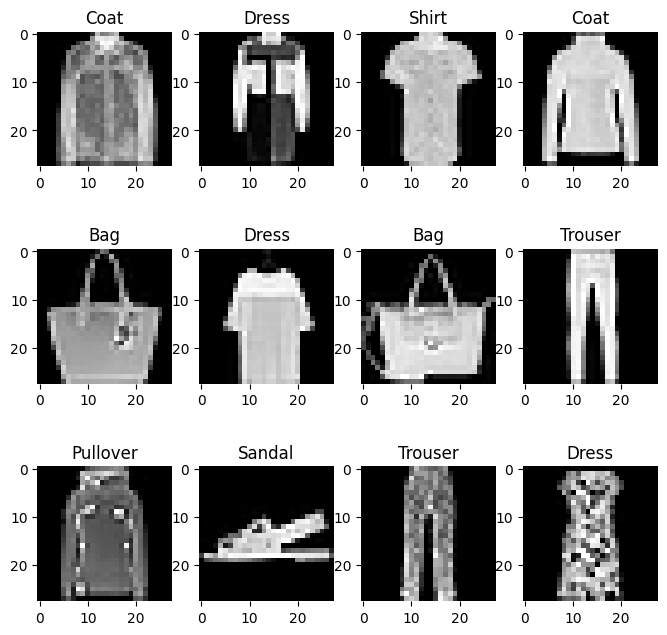

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

## get a batch of data
images, labels = next(iter(train_loader))

# Define a dictionary mapping class indices
image_dict = {0:'T-shirt/Top', 1:'Trouser', 2:'Pullover', 3:'Dress',
              4:'Coat', 5:'Sandal', 6:'Shirt', 7:'Sneaker',
              8:'Bag', 9:'Ankle Boot'}

fig = plt.figure(figsize=(8,8))

print(images.size())

for i in np.arange(1, 13):
    ax = fig.add_subplot(3,4,i, frameon=False)
    img = images[i][0]
    ax.set_title(image_dict[labels[i].item()]) # Set title based on class label
    plt.imshow(img, cmap='gray') # Display the image in grayscale

Architecture

1. A convolution layer for extracting features.
2. Batchnorm layer for normalizing the weights in the hidden layers.
3. ReLU activation function for the non-linearity between layers.
4. Fully connected layers in the end.


---


Model:
Convolutional neural network architecture for our dataset.
* Convolution layer output_channels-16 kernel_size=3 stride=1 padding-1
* Batchnormalization layer
* ReLU activation layer
* Maxpool layer kernel_size=2 stride=2


---


* Convolution layer output_channels-32 kernel_size=3 stride=1 padding-1
* Batchnormalization layer
* ReLU activation layer
* Maxpool layer kernel_size=2 stride=2


---


* Convolution layer output_channels-64 kernel_size=5 stride=1 padding-2
* Batchnormalization layer
* ReLU activation layer
* Maxpool layer kernel_size=2 stride=2


---


Fully connected layer - number of classes


In [5]:
import torch.nn as nn

class Model(nn.Module):
    ## init function is the constructor and we define all the layers used in our model.
    def __init__(self, num_classes=10):
        super(Model, self).__init__()

        # define a convolutional layer with 16 channels, kernel_size=3, stride=1 and padding=1
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)

        # define a batch normalization layer
        self.bn1 = nn.BatchNorm2d(num_features=16)

        # define a ReLU layer
        self.relu1 = nn.ReLU()

        # define a maxpool layer with kernel_size=2, stride=2
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # define a convolutional layer with 32 channels, kernel_size=3, stride=1 and padding=1
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)

        # define a batch normalization layer
        self.bn2 = nn.BatchNorm2d(num_features=32)

        # define a ReLU layer
        self.relu2 = nn.ReLU()

        # define a maxpool layer with kernel_size=2, stride=2
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # define a convolution layer with 64 channels, kernel_size=5, stride=1 and padding=2
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2)

        # define a batchnorm layer
        self.bn3 = nn.BatchNorm2d(num_features=64)

        # define a relu layer
        self.relu3 = nn.ReLU()

        # define a maxpool layer with kernel_size=2, stride=2
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # define a fully connected layer from resulting dimension -> number of classes
        self.fc = nn.Linear(in_features=576, out_features=num_classes)

    def forward(self, x):
        # Take the output x and feed it back to the next layer
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.pool3(x)
        x = self.flatten(x)
        x = self.fc(x)

        return x

    # Note that before the fully connected(fc) layer, the output is a feature map with size (N,C,H,W)
    # but a fully connected layers expects a input of size (N, dimension). Therefore, before passing the output of
    # maxpool layer to the fc layer, we must first flatten the output of previous layer to a size (N,C*H*W)
    # and then pass it to the fully connected layer, like x = flatten(x)
    # Define the flatten function below, use the x = x.view() function
    def flatten(self, x):
        N, C, H, W = x.size()
        #reshape x to (N, C*H*W)
        x = x.view(x.size(0), -1)

        return x

In [6]:
# The Model object is initialized by providing num_classes as input
# The network takes input Tensors of dimensions (B,1,28,28), where B is arbitrary batch_size,
# 1 is the number of channels in the grayscale image and 28 is image size
# The output of the network is Tensor of dimensions (B,10) where 10 is the num_classes

model = Model(num_classes=10)
test_input1 = torch.randn(16,1,28,28)
out1 = model(test_input1)
test_input2 = torch.rand(20,1,28,28)
out2 = model(test_input2)

print(out1.shape)
print(out2.shape)

torch.Size([16, 10])
torch.Size([20, 10])


In [7]:
# Setting up a few learning parameters
learning_rate = 1e-2
decayRate = 0.999
epochs = 5
number_of_classes = 10

Initialize the CNN Model

In [8]:
## First define an instance of the model to train
model = Model(num_classes=number_of_classes)
print(model)

# Move the model to the gpu, check if gpu is available
if is_cuda:
  model = model.cuda()

# define the loss 'criterion' as nn.CrossEntropyLoss() object
criterion = nn.CrossEntropyLoss()

# Initialize the Adam optimizer for the model.parameters() using the learning_rate
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# This is the learning rate scheduler. It decreases the learning rate as we approach convergence
my_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decayRate)

Model(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=576, out_features=10, bias=True)
)


In [11]:
out = torch.FloatTensor([[0.1,0.8,0.05,0.05]])
true = torch.LongTensor([1])

**Training the Model**
The training loop is setup in the following way:

* For every batch in the defined number of epochs
* Move the images and labels to the gpu by checking is_cuda
* Extract output by passing images through the model
* Pass the output and ground truth to the loss criterion for batch loss
* Clear the gradients
* Backpropagate (compute gradients w.r.t the parameters) using backward()
* Update the parameters with a single optimization step
* Update the training loss for plots
* Repeat

In [12]:
## training loop

## Number of epochs the model runs

def train_model(epochs=25, validate=True):
    '''
    A function to train the model on the dataset and returns the trained model, training loss and
    validation loss for every epoch.
    '''
    train_loss = []
    val_loss = []

    for epoch in range(epochs):
        # Iterate through the batches in the data
        training_loss = 0.0
        validation_loss = 0.0

        model.train()
        itr = 0
        for (images,labels)  in train_loader:
            # Move the images and labels to the gpu by checking is_cuda
            if is_cuda:
                images, labels = images.cuda(), labels.cuda()
            # Extract outputs by passing images through the model
            outputs = model(images)
            # Estimate loss using criterion(.) with 'outputs' and 'labels'
            loss = criterion(outputs, labels)
            # Clear the gradients with .zero_grad()
            optimizer.zero_grad()
            # Estimate gradients using .backward()
            loss.backward()
            # Update model with .step()
            optimizer.step()
            # Update learning_rate with with a .step using my_lr_scheduler
            my_lr_scheduler.step()
            # Add loss to training_loss
            training_loss += loss.item()

            if itr%100 == 0:
                print('Epoch %d/%d, itr = %d, Train Loss = %.3f, LR = %.3E'\
                      %(epoch, epochs, itr, loss.item(),optimizer.param_groups[0]['lr']))
            itr += 1
        train_loss.append(training_loss/len(train_loader))
        print('------------------------------------------------')

        # During validation we do not update gradients. We set model to eval()
        if validate:
            model.eval()
            with torch.no_grad():
                itr = 0
                for (images,labels)  in valid_loader:
                    if is_cuda:
                        images, labels = images.cuda(), labels.cuda()
                    # Get 'outputs' using model and images
                    outputs = model(images)
                    # Estimate loss using criterion(.) with 'outputs' and 'labels'
                    loss = criterion(outputs, labels)
                    # Add loss to 'validation_loss'
                    validation_loss += loss.item()

                    if itr%100 == 0:
                        print('Epoch %d/%d, itr = %d, Val Loss = %.3f, LR = %.3E'\
                              %(epoch, epochs, itr, loss.item(),optimizer.param_groups[0]['lr']))
                    itr += 1
                val_loss.append(validation_loss/len(valid_loader))
                print('################################################')

    return model, train_loss, val_loss


In [13]:
start = time.time()
trained_model, train_loss, val_loss = train_model(epochs, validate=True)
end = time.time()
print('Time to train in seconds ',(end - start))

Epoch 0/5, itr = 0, Train Loss = 2.486, LR = 9.990E-03
Epoch 0/5, itr = 100, Train Loss = 0.849, LR = 9.039E-03
Epoch 0/5, itr = 200, Train Loss = 0.463, LR = 8.178E-03
Epoch 0/5, itr = 300, Train Loss = 0.331, LR = 7.400E-03
Epoch 0/5, itr = 400, Train Loss = 0.384, LR = 6.695E-03
Epoch 0/5, itr = 500, Train Loss = 0.387, LR = 6.058E-03
Epoch 0/5, itr = 600, Train Loss = 0.306, LR = 5.481E-03
Epoch 0/5, itr = 700, Train Loss = 0.387, LR = 4.959E-03
------------------------------------------------
Epoch 0/5, itr = 0, Val Loss = 0.285, LR = 4.491E-03
Epoch 0/5, itr = 100, Val Loss = 0.168, LR = 4.491E-03
################################################
Epoch 1/5, itr = 0, Train Loss = 0.439, LR = 4.487E-03
Epoch 1/5, itr = 100, Train Loss = 0.305, LR = 4.060E-03
Epoch 1/5, itr = 200, Train Loss = 0.345, LR = 3.673E-03
Epoch 1/5, itr = 300, Train Loss = 0.263, LR = 3.324E-03
Epoch 1/5, itr = 400, Train Loss = 0.281, LR = 3.007E-03
Epoch 1/5, itr = 500, Train Loss = 0.226, LR = 2.721E-03


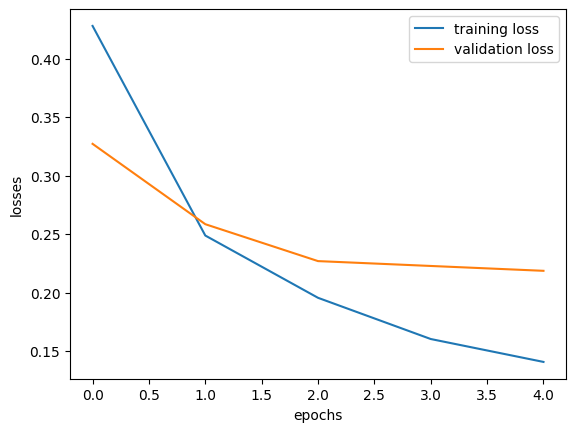

In [14]:
# Plot the losses
it = np.arange(epochs)
plt.plot(it, train_loss, label='training loss')
plt.plot(it, val_loss, label='validation loss')
plt.xlabel('epochs')
plt.ylabel('losses')
plt.legend(loc='upper right')
plt.show()

**Testing the Classsification**

In the testing loop we don't update the weights. The trained model is tested for all the samples in test data to compute the accuracy and observe how well the model is generalizing to the unseen data.

The testing loop is setup in the following way:

For every batch in the testing data
* Put the model in the evaluation mode and turn off the gradients

* Move the images and labels to the device available
* Extract output from the model for the input
* Compute the prediction class by choosing the one with maximum probability in the predictions.
* Compare the prediction classes with true classes.
* Calculate accuracy
* Update test_loss for plots
* Repeat

In [18]:
## Testing Loop

def evaluate_model(model, loader):
    '''
    A function to test the trained model on the dataset and print the accuracy on the testset.
    '''
    model.eval()
    with torch.no_grad():
        correct = 0
        total_samples = 0
        for images, labels in loader:
            ## Move the images and labels to gpu if is_cuda
            ## Get the output of the model by passing images as input to the model
            ## Estimate the index of the highest output in each row, that is the predicted label
            ## Compare predictions with ground truth for number of correct samples

            if is_cuda:
                images, labels = images.cuda(), labels.cuda()

            outputs = model(images)
            _, predictions = torch.max(outputs, 1)

            p = (predictions == labels)
            correct += p.sum().item()
            total_samples += labels.size(0)

        accuracy = correct/total_samples*100
        print("Total Accuracy on the Input set: {} %".format(accuracy))
        return accuracy

In [19]:
tr_acc = evaluate_model(model, train_loader)
ts_acc = evaluate_model(model, test_loader)
print('Train Accuracy = %.3f'%(tr_acc))
print('Test Accuracy = %.3f'%(ts_acc))

Total Accuracy on the Input set: 95.72708333333333 %
Total Accuracy on the Input set: 91.73 %
Train Accuracy = 95.727
Test Accuracy = 91.730


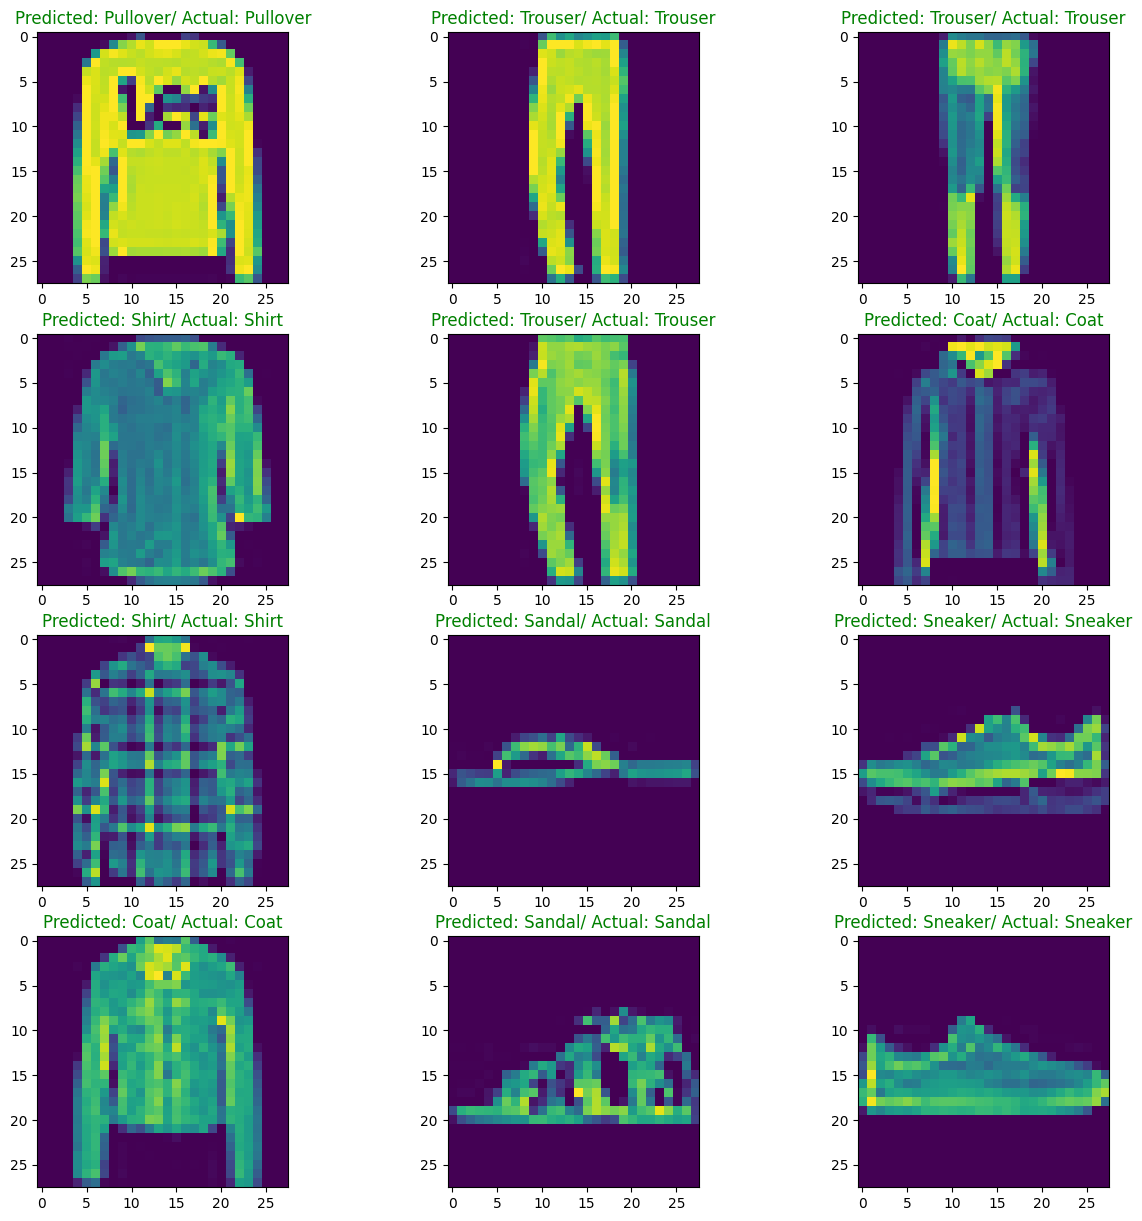

In [20]:
## Visualize the test samples with predicted output and true output
images, labels = next(iter(test_loader))
# images = images.numpy()
if is_cuda:
  images = images.cuda()
  labels = labels.cuda()

out = model(images)
_, preds = torch.max(out, dim=1)

images = images.to('cpu').numpy()

fig = plt.figure(figsize=(15,15))
for i in np.arange(1, 13):
    ax = fig.add_subplot(4, 3, i)
    plt.imshow(images[i][0])
    ax.set_title("Predicted: {}/ Actual: {}".format(image_dict[preds[i].item()], image_dict[labels[i].item()]),
                color=('green' if preds[i] == labels[i] else 'red'))